Setup the environment
===
- Install the required packages
- Import the required libraries

In [1]:
%pip install kagglehub
%pip install torchvision

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [2]:
import kagglehub # used to download the dataset
import numpy as np
import random
from tqdm.notebook import tqdm, trange

from torch.utils.data import DataLoader
from torch.utils.data import random_split
from torchvision import transforms
from torchvision.datasets import ImageFolder

import torch
import torch.nn as nn
import torch.nn.functional as F

import matplotlib.pyplot as plt

# Custom imports
from data import ImageLabelDataset
from plot import show_selected_images_labels, visualize_predictions

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"

def set_seed(seed: int = 42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)

    # If using GPU
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # for multi-GPU setups

    # For deterministic behavior
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed()

Inspect the dataset
===

In [4]:
kaggle_name = "bhavikjikadara/dog-and-cat-classification-dataset"
path = kagglehub.dataset_download(kaggle_name) + "/PetImages"

print("Path to dataset files:", path)

Path to dataset files: /home/matthiash/.cache/kagglehub/datasets/bhavikjikadara/dog-and-cat-classification-dataset/versions/1/PetImages


In [5]:
cat_dir, dog_dir = path + "/Cat", path + "/Dog"
img_folder, label_folder = "images", "labels"

image_transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((128, 128)),     # optional
    transforms.ToTensor(),             # <-- required
    transforms.Normalize(mean=[0.5], std=[0.5])
])

label_map = np.array([
    "cat", "dog"
])

dataset = ImageFolder(root=path, transform=image_transform)
train_dataset, test_dataset = random_split(dataset, [len(dataset)-32, 32])

train_loader = DataLoader(train_dataset, batch_size=48, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32)

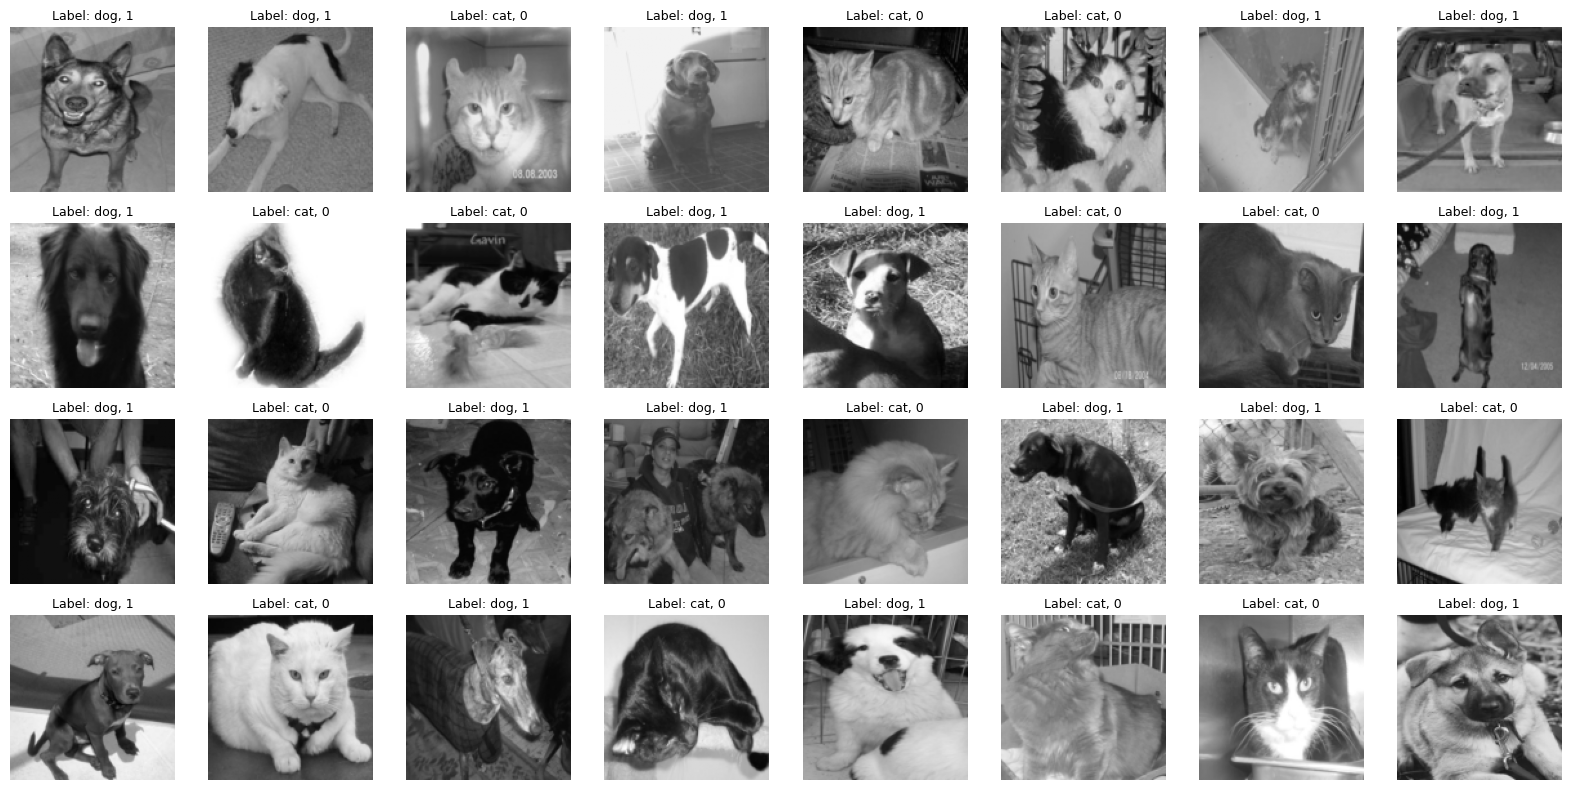

In [6]:
image, label = next(iter(test_loader))
description = label_map[label.to(int)]
show_selected_images_labels(image,label,description, rows=4, cols=8)

Takeaways and Notes
===
- The dataset seems diverse: different resolutions, angles, greyscale vs color images ...
- Some images have clear facial expressions, while others are more ambiguous. Hence, we also would expect some ambiguity for our trained classifier.

Additional Points to Consider
---
- Better image preprocessing: consider resizing, cropping, or normalizing images to ensure consistency. This could also involve machine learning techniques.
- Class balancing: if some classes are underrepresented, consider oversampling or undersampling techniques to balance the dataset.

Next steps
---
To ease the following exercise at first we will simplify the classes. Instead of considering the nine original categories encoding different emotions we will group them into "bad" and "good" emotions and focus first on a binary classification problem. Afterwards, we will come back to the original dataset.

The Bayesian Point of View - how to define our Classifier?
===
Let us start with the definition of our task:
> Given a *single* image of a face, we want to classify the facial expression into one of two emotion categories: good and bad emotion.

In more mathematical terms:
> Given a *single* image $x \in \mathbb{R}^{\text{width} \times \text{height}}$, we want to estimate the probabilities
$\mathbb{P}(x \text{ shows a bad emotion})$ and $\mathbb{P}(x \text{ shows a good emotion})$. Since in our case, an image can either show a good or a bad emotion, it suffices to estimate one probability, e.g. $p = \mathbb{P}(x \text{ shows a bad emotion})$. Afterwards, we immediately know the other probability since $\mathbb{P}(x \text{ shows a good emotion})=1-p$.

Even more mathematically:
> We want to learn a function $f: \mathbb{R}^{\text{width} \times \text{height}} \to [0,1]$ such that $f(x) \approx \mathbb{P}(x \text{ shows a bad emotion})$.

But why are we talking about probabilities?
---
Let us assume we have a coin. But instead of the outcomes "head" or "number" the sides of our coin shows the categories "bad emotion" and "good emotion". Also, we do not expect to have a "fair" coin - some emotions are more likely to be shown than others.
Basically, the analogy of tossing our coin is that we choose randomly one person of the whole world, look at her face, and either observe a "good" or "bad" emotion.
What is the probability that this person would show a bad emotion?

First answer: how should we know?

Second answer: let us use our dataset! Count all the pictures showing a bad emotion and divide by the total number of pictures - this gives us the sought probability.

In [7]:
labels = np.array(dataset.targets)

N = len(labels) # number of images in the dataset
cat_count = (labels == 0).sum()
p_cat = cat_count / N
display(f"The probability of a randomly chosen image showing a cat is {100 * p_cat:.2f}%.")

'The probability of a randomly chosen image showing a cat is 50.00%.'

So now let us toss our coin one more time and pic another person from the world. Let us name this person Alice.
Before looking at Alice's face, we can now say that there is a 56% chance that Alice shows a bad emotion - nice.

But now let us actually *look* at Alice's face. We see that she has really red cheeks, her eyebrows are furrowed, and her mouth is pressed together. It looks like she is angry - a bad emotion. But are we still believing that there is only a 56% chance that she *is* actually in a bad mood?

Updating the Probability
---
Before, we calculated $\mathbb{P}(\text{an image shows a bad emotion}) \approx 0.56$ where we did not refer to an actual image. Now, we have a particular image $x \in \mathbb{R}^{\text{width} \times \text{height}}$ observed. Let us say a picture of Alice. We want to calculate the probability that Alice is in a bad mood, given the picture of her:
$$
\mathbb{P}(\text{Alice is showing a bad emotion} | \text{ a picture } x \text{ of Alices's face}) = ?
$$
The $$|\text{ a picture } x \text{ of Alices's face}$$ notation means that we now have this additional information of a picture of Alice.

Mixing in Neural Networks
---
How would we, as humans, decide if Alice *is* in a bad mood given the picture of her? We would conclude this because of the red cheeks, the eyebrows, her overall facial expression. The key idea:
> There are certain features in pictures of faces which indicate if the person is in a bad mood.

But what are this features? We could predefine certain features and hope that they indicate what we want like the position of the eyebrows. This is error prone and in many tasks impossible. If I chose the eye color only as the indicator for my classifier, it will never make a good job.

We want to learn the features from the data we have! We model our probability with a neural network.

Remember the function $f(x)\approx \mathbb{P}(x \text{ shows a bad emotion})$ from before? Our $f(x)$ exactly is our neural network. Because we like fancy symbols, we do not write $f(x)$ but use the notation $\mathcal N_\theta(x)\approx \mathbb{P}(x \text{ shows a bad emotion})$.

Convolutional Neural Networks
---
Our network $N_\theta(x)$ takes an image $x \in \mathbb{R}^{\text{width} \times \text{height}}$ as input and gives us a probability as a number in $[0,1]$. Convolutional neural networks are exactly these type of networks which can reduce a whole image to a single number.

In [8]:
class BinaryClassifierCNN(nn.Module):
    def __init__(self):
        super(BinaryClassifierCNN, self).__init__()

        self.conv_layers = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=4, padding=0),  # (3, 128, 128) → (32, 128, 128)
            nn.ReLU(),
            nn.MaxPool2d(2),                             # → (32, 64, 64)

            nn.Conv2d(32, 64, kernel_size=4, padding=0), # → (64, 64, 64)
            nn.ReLU(),
            nn.MaxPool2d(2),                             # → (64, 32, 32)

            nn.Conv2d(64, 128, kernel_size=4, padding=0),# → (128, 32, 32)
            nn.ReLU(),
            nn.MaxPool2d(2),                             # → (128, 16, 16)
        )

        self.fc_layers = nn.Sequential(
            nn.Flatten(),                                 # → (128 * 16 * 16,)
            nn.Linear(128 * 13 * 13, 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, 1),
            #nn.Sigmoid()                                  # Output ∈ [0, 1]
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = self.fc_layers(x)
        return x

CNN = BinaryClassifierCNN().to(device)

The Sigmoid Function
---
The last function of our network is the so-called sigmoid function
$$
\sigma(t) = \frac{1}{1+e^{-t}}.
$$
In 1D, $\sigma: \mathbb R \longrightarrow [0,1]$ which means in our case that $\sigma(t)$ can be interpreted as a probability!

Note however that $t \in \mathbb R$ here does not represent an image! Rather, $t$ is already an intermediate output of our neural network, which transformed an input image $x \in \mathbb{R}^{\text{width} \times \text{height}}$ to some arbitrary real number $t \in \mathbb R$ and then applies on top $\sigma(t)$ to get something in $[0,1]$.

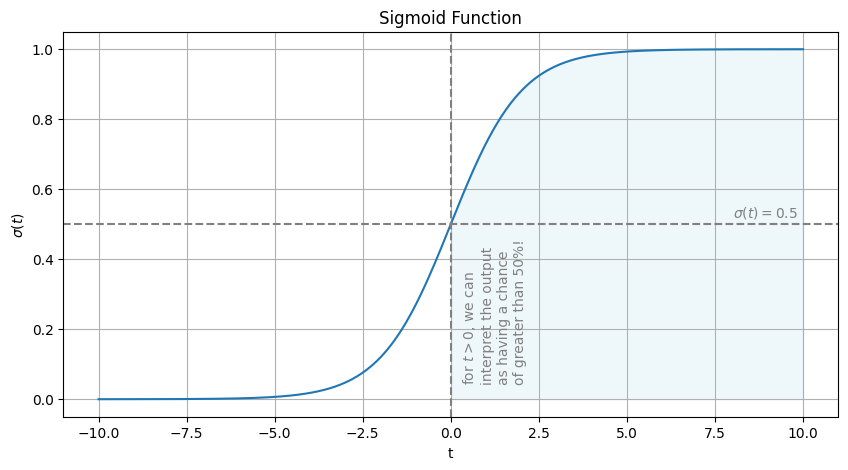

In [9]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

# Input range
t = np.linspace(-10, 10, 1000)
y = sigmoid(t)

# Plot
plt.figure(figsize=(10,5))
plt.plot(t, y)
plt.title("Sigmoid Function")
plt.xlabel("t")
plt.ylabel(r"$\sigma(t)$")
plt.grid(True)
plt.axhline(0.5, color='gray', linestyle='--')  # Midline
plt.axvline(0, color='gray', linestyle='--')    # Center point

# Annotate horizontal line
plt.text(8, 0.52, r"$\sigma(t)=0.5$", color='gray', fontsize=10)

# Annotate vertical line
plt.text(0.3, 0.05, 'for $t > 0$, we can \ninterpret the output \nas having a chance \nof greater than 50%!', color='gray', fontsize=10, rotation=90)

plt.fill_between(t, y, where=(t >= 0), color='lightblue', alpha=0.2, label=r'Area: $x \geq 0$')


plt.show()

Testing our Neural Network *before Training*
---
We can already plug in some images into our neural network and see what we get.

For this purpose we define the "accuracy" as the number of correctly classified pictures divided by the total number of pictures, i.e.
$$
\text{accuracy} = \frac{\text{\# correctly classified}}{\text{\# total}}
$$

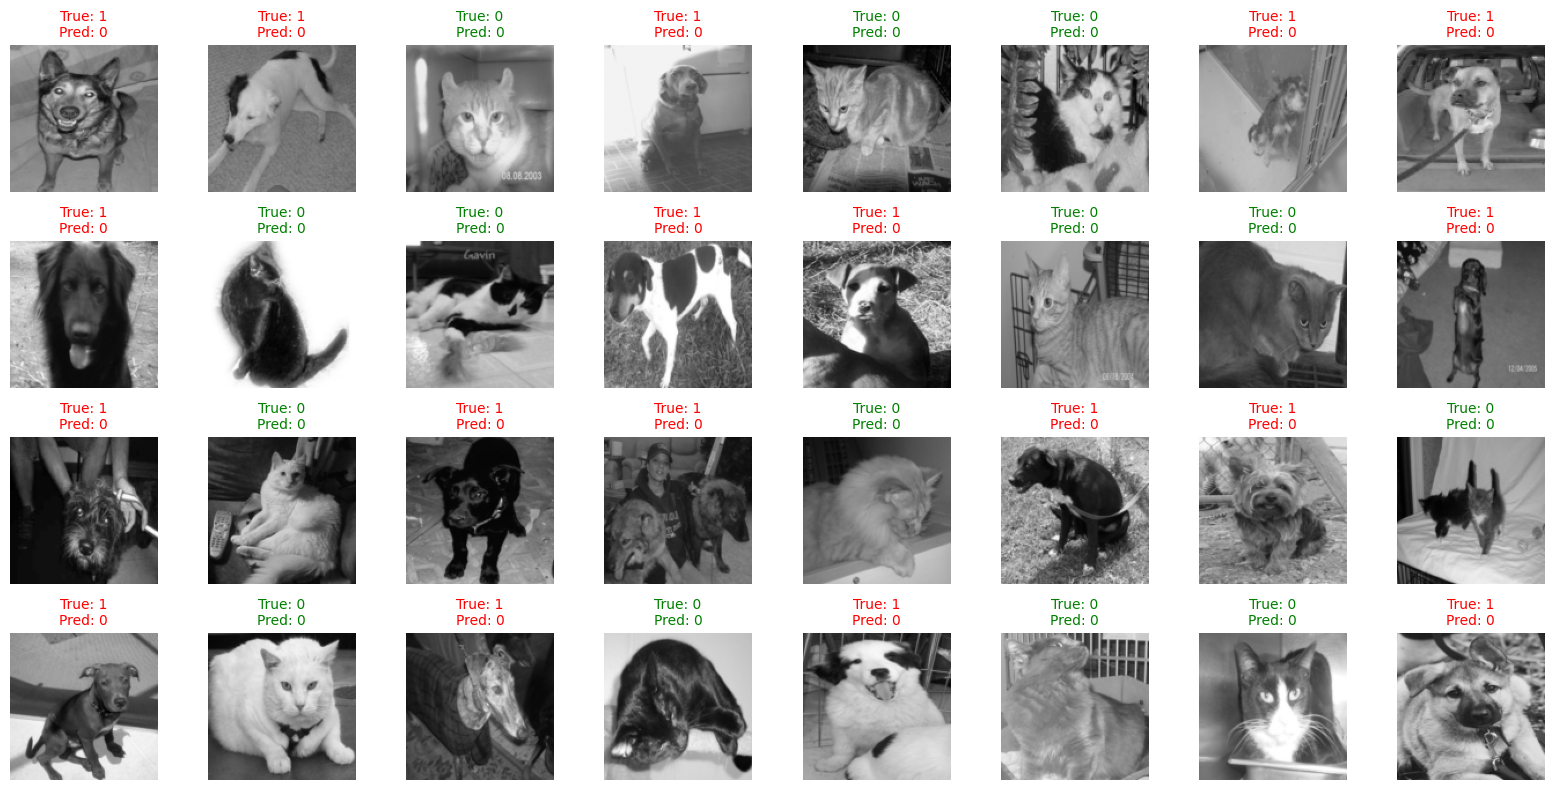

Correctly classified:  14
Wrongly classified:  18
Accuracy:  0.4375


In [10]:
image, label = next(iter(test_loader))
y_true = label.detach().cpu().numpy().squeeze()
y_pred = (CNN(image.to(device)).detach().cpu().numpy() > 0.5).squeeze().astype(int)

def accuracy(model):
    with torch.no_grad():
        y_pred = (model(image.to(device)).detach().cpu().numpy() > 0.5).squeeze().astype(int)
        accuracy = (y_pred == y_true).mean()
    return accuracy

visualize_predictions(image, y_true, y_pred, rows=4, cols=8)

true_count = y_true == y_pred
false_count = y_true != y_pred
print("Correctly classified: ", np.sum(true_count))
print("Wrongly classified: ", np.sum(false_count))
print("Accuracy: ", accuracy(CNN))

Training our Neural Network
===

So far it does not look like our network "knows" anything on how to classify correctly the people's moods. Rather, it seems to randomly guess the mood state. We need to tell the network somehow how people with bad mood look like.

Learning by Examples
---
How did you "learn" how people in bad mood look like? I guess you have already seen enough angry, sad, tired, ... people to know how they look. But not only this. When you really learned about the emotions like "This is Alice. She is angry." you learned somehow from labelled data (you saw Alice's face with a description on her emotions) and then were able to generalise to knew faces. This is exactly what we are now doing with our neural network.

In [11]:
loss_func = nn.BCEWithLogitsLoss().to(device)
pars = CNN.parameters()
optimizer = torch.optim.Adam(pars, lr=0.0001)

In [ ]:
%matplotlib notebook
steps_per_epoch = len(train_loader)
epochs = 500

show_every = 50 #how often to show the loss
ob_val = np.zeros(epochs*steps_per_epoch)
acc = np.zeros(epochs*steps_per_epoch)

CNN.train() # set to training mode

test_image, test_label = next(iter(test_loader))
test_image = test_image.to(device)
test_label = test_label.to(device)

i = 0

plt.ioff()
fig, ax = plt.subplots()
line, = ax.plot([], [], 'b-')
ax.set_xlabel('Step')
ax.set_ylabel('Loss')
ax.set_title('Live Training Loss')
plt.ion()
plt.show(block=False)

for epoch in trange(epochs, desc="Epochs", leave=True):  # loop over the dataset multiple times

    pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}", unit="batch", leave=False, mininterval=0.5)

    for images, labels in pbar:

        images = images.to(device)
        labels = labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # Evaluate the loss and carry out gradient descent step
        loss = loss_func(CNN(images).squeeze(),labels.to(torch.float32))
        loss.backward()
        optimizer.step()

        # print loss
        ob_val[i] = loss.item()
        acc[i] = accuracy(CNN)

        #pbar.set_postfix(loss=f"{ob_val[i]:.4f}", accuracy=f"{acc[i]:.4f}")

        if np.remainder(i,show_every)==0:
            line.set_data(range(i), ob_val[:i])
            ax.relim()
            ax.autoscale_view()
            fig.canvas.draw_idle()
            fig.canvas.flush_events()
            plt.pause(0.001)

        i += 1



print('Finished Training')

<IPython.core.display.Javascript object>

Epochs:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 1:   0%|          | 0/521 [00:00<?, ?batch/s]

/home/matthiash/miniconda3/envs/pytorch/lib/python3.13/site-packages/PIL/TiffImagePlugin.py:950: UserWarning: Truncated File Read
  warnings.warn(str(msg))


Epoch 2:   0%|          | 0/521 [00:00<?, ?batch/s]

Epoch 3:   0%|          | 0/521 [00:00<?, ?batch/s]

In [ ]:
image, label = next(iter(train_loader))
y_true = label.detach().cpu().numpy().reshape(-1,1)
y_pred = (CNN(image).detach().cpu().numpy() < 0.5).astype(int)

visualize_binary_predictions(image, y_true, y_pred, rows=4, cols=4)

true_count = y_true == y_pred
false_count = y_true != y_pred
print("Correctly classified: ", np.sum(true_count))
print("Wrongly classified: ", np.sum(false_count))